In [1]:
#%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
matplotlib.rcParams['figure.figsize'] = [16*1., 9*1.]
import pandas as pd
import numpy as np
import cv2
import os
from PIL import Image

# Directory containing your images
image_dir = './documents'  # Current directory

# List all files in the directory
image_files = os.listdir(image_dir)

# Open each image file
images = [Image.open(os.path.join(image_dir, file)).convert('L') for file in image_files if file.endswith(('.png', '.jpg', '.jpeg'))]

In [2]:
height, width = 2, 3

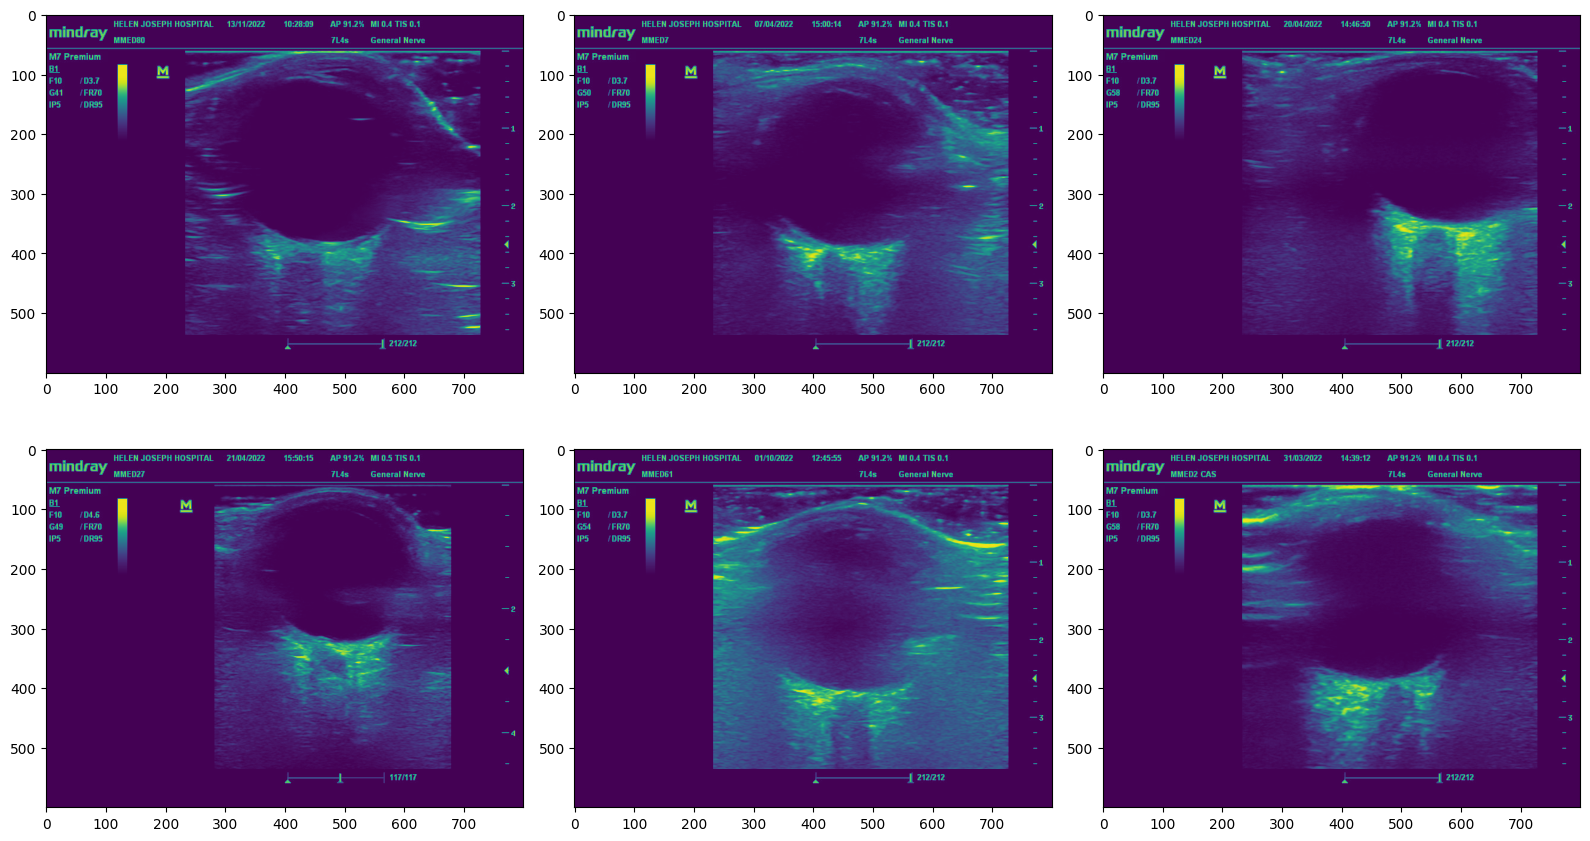

In [3]:
fig, ax = plt.subplots(height, width)
# Display the first images
for i in range(height * width):
    ax[i // width, i % width].imshow(images[i])

plt.tight_layout()

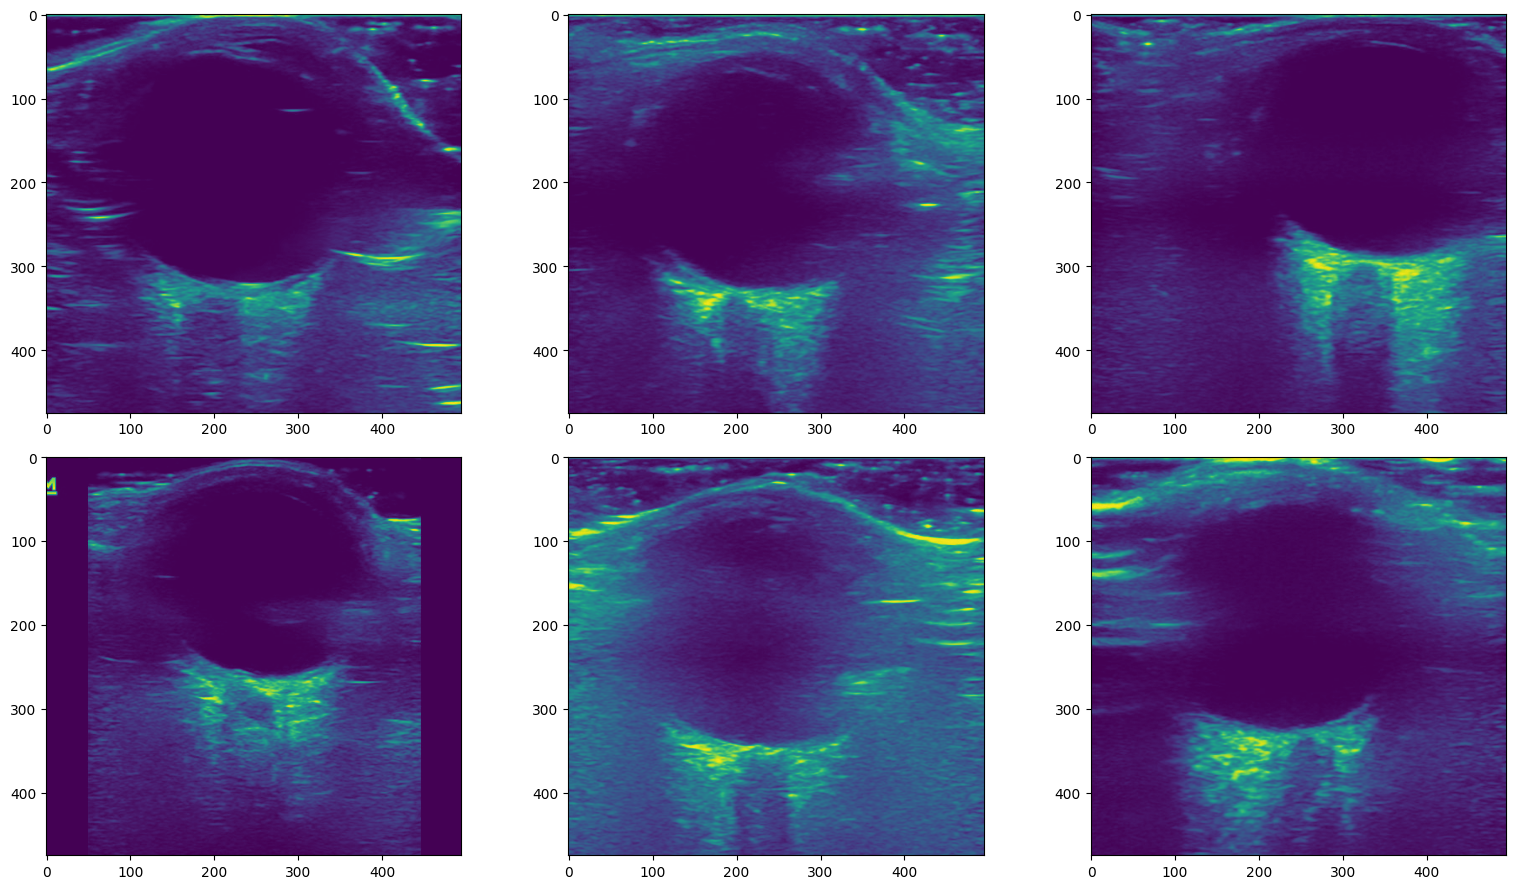

In [4]:
# Image field size:
left = 232
top = 60
img_width = 495
img_height = 475
right = left + img_width
bottom = top + img_height
cropped_images = [img.crop((left,top,right,bottom)) for img in images]

cv_images = [np.array(image) for image in cropped_images]

fig, ax = plt.subplots(height, width)
# Display the first images
for i in range(height * width):
    ax[i // width, i % width].imshow(cv_images[i])

plt.tight_layout()

In [5]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15
MAX_DELTA = 200    # Maximum offset between images. This should be crop_left - crop_width on the left and respectively for each offset direction.
crop_top = 290
crop_height = 100
crop_bottom = crop_top + crop_height
crop_left = 215
crop_width = 125
crop_right = crop_left + crop_width
MIN_DELTA_X = -crop_left
MAX_DELTA_X = img_width - crop_right
MIN_DELTA_Y = -crop_top
MAX_DELTA_Y = img_height - crop_bottom
print(f"{crop_bottom=}, {img_height=}")
print(f"{MIN_DELTA_X=}, {MAX_DELTA_X=}, {MIN_DELTA_Y=}, {MAX_DELTA_Y=}")
print(f"{-crop_left=}, {200=}, {-crop_top=}, {80=}")

from sklearn.cluster import DBSCAN
#cluster_model = DBSCAN(eps=6, min_samples=5)
cluster_model = DBSCAN(eps=10, min_samples=5)

def alignImages(im1, im2):
  if len(im1.shape) == 3:
      # Convert images to grayscale
      im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
      im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
  else:
      im1Gray = im1
      im2Gray = im2
 
  # Detect ORB features and compute descriptors.
  orb = cv2.ORB_create(MAX_FEATURES)
  keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
  keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
 
  # Match features.
  #matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
  matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_L1)
  matches = list(matcher.match(descriptors1, descriptors2, None))
 
  # Sort matches by score
  matches.sort(key=lambda x: x.distance, reverse=False)
 
  # Remove not so good matches
  numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
  matches = matches[:numGoodMatches]
 
  # Draw top matches
  match_image = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
 
  # Extract location of good matches
  points1 = np.zeros((len(matches), 2), dtype=np.float32)
  points2 = np.zeros((len(matches), 2), dtype=np.float32)

  deltas = np.zeros((len(matches), 2))    # x, y offset between points matched in both images
  for i, match in enumerate(matches):
      points1[i, :] = keypoints1[match.queryIdx].pt
      points2[i, :] = keypoints2[match.trainIdx].pt
      deltas[i] = points2[i] - points1[i]

  # Remove deltas larger than the image field
  deltas = deltas[np.where((deltas[:,0] > MIN_DELTA_X) & (deltas[:,0] < MAX_DELTA_X) & (deltas[:,1] > MIN_DELTA_Y) & (deltas[:,1] < MAX_DELTA_Y))]

  # Cluster feature offsets
  associations = cluster_model.fit_predict(deltas)
  clusters = np.unique(associations)
  cluster_points = np.where(associations == 0)    # Cluster #0 is the first cluster, #-1 is the unclustered points
  offset = np.average(deltas[cluster_points], axis=0)    # Return the most likely offset
  return offset, deltas, cluster_points, match_image
    
  assert len(points1) == len(points2)
  distances = np.zeros(len(matches))
  deltas_x, deltas_y = np.zeros(len(matches)), np.zeros(len(matches))
  sum_delta_x, sum_delta_y, sum_distance = 0, 0, 0
  for i, (point1, point2) in enumerate(zip(points1, points2)):
      deltas_x[i] = point2[0] - point1[0]
      deltas_y[i] = point2[1] - point1[1]
      distance = sqrt(deltas_x[i]**2 + deltas_y[i]**2)
      distances[i] = distance
      sum_delta_x += deltas_x[i]
      sum_delta_y += deltas_y[i]
      sum_distance += distances[i]
  avg_delta_x = sum_delta_x / len(points1)
  avg_delta_y = sum_delta_y / len(points1)
  avg_distance = sum_distance / len(points1)

  selection = (distances < 250)
  offset_left = np.average(deltas_x[selection])
  offset_top = np.average(deltas_y[selection])
  resid_x = deltas_x - offset_left
  resid_y = deltas_y - offset_top
  std_x = np.std(resid_x)
  std_y = np.std(resid_y)
  #print(std_x, std_y)
  selection = (distances < 100) & ((abs(resid_x) + abs(resid_y)) < 45)# & (deltas_y > 0)
  offset_left = np.average(deltas_x[selection])
  offset_top = np.average(deltas_y[selection])
  return (offset_left, offset_top, deltas, selection)

crop_bottom=390, img_height=475
MIN_DELTA_X=-215, MAX_DELTA_X=155, MIN_DELTA_Y=-290, MAX_DELTA_Y=85
-crop_left=-215, 200=200, -crop_top=-290, 80=80


[ 86.6931015  -67.22214661]
-1
0


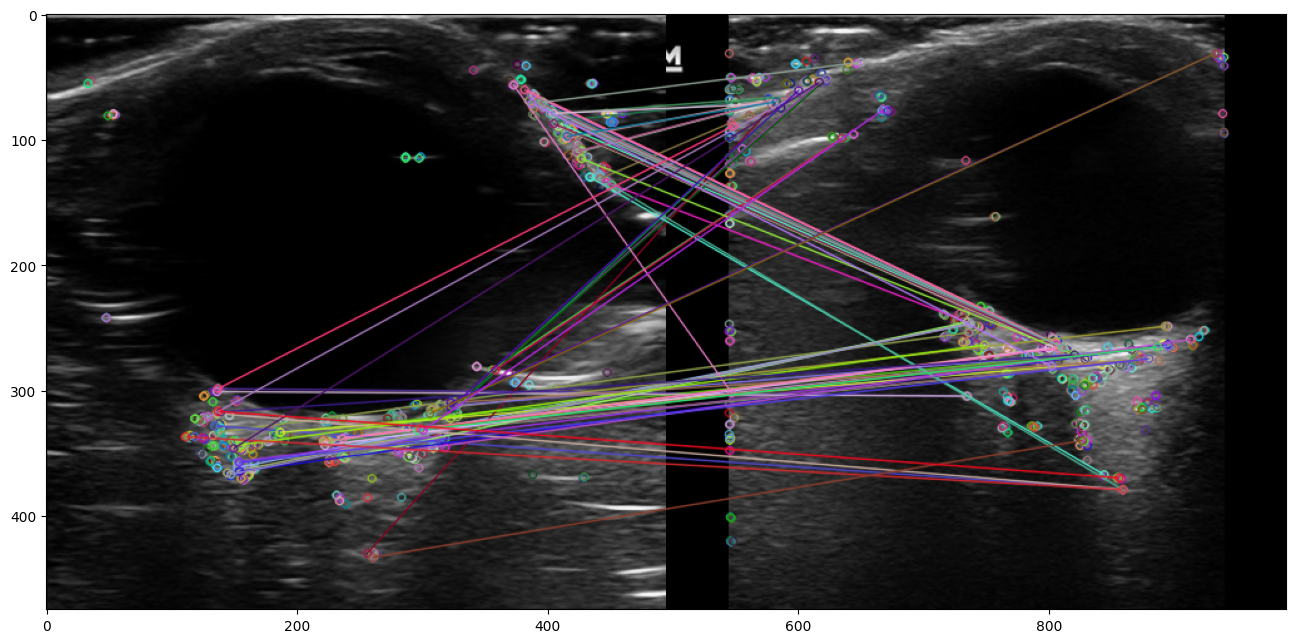

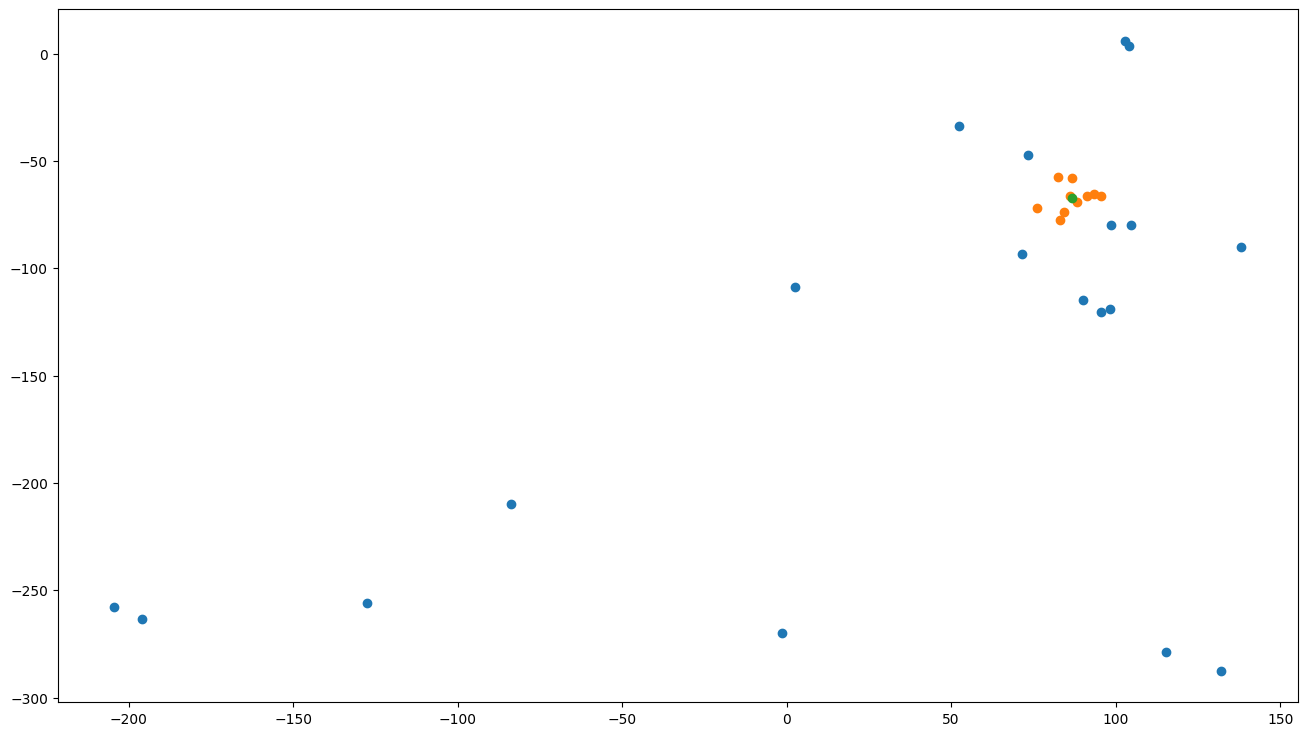

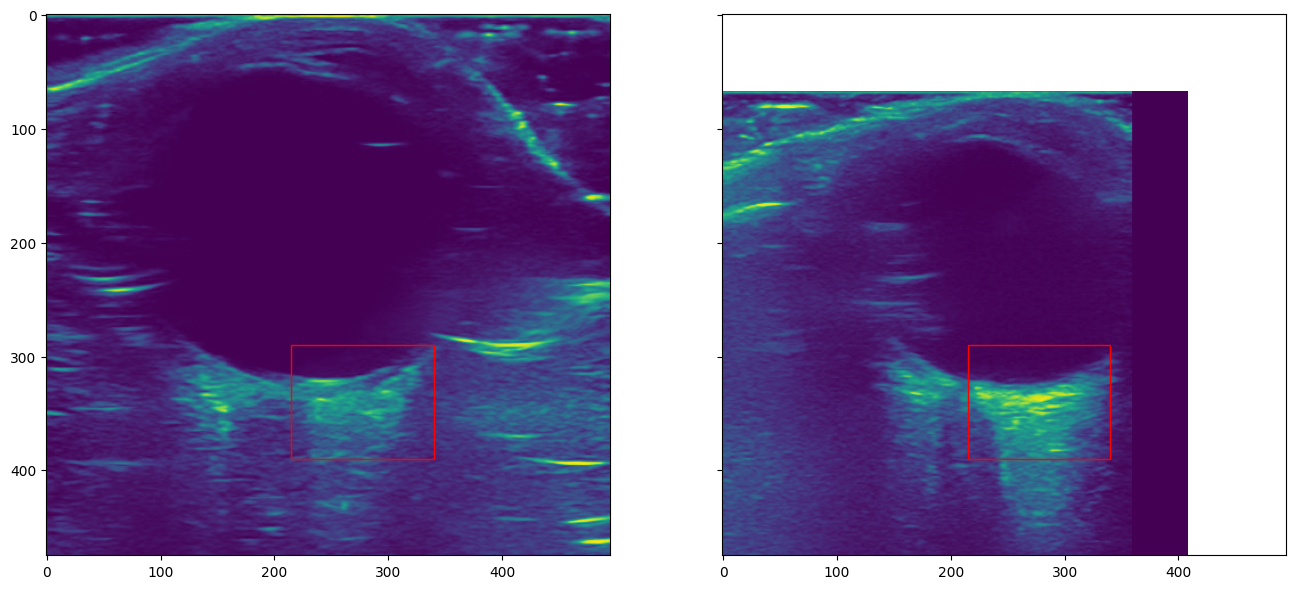

In [6]:
img_no = 173
img_no = 109
img_no = 105
#img_no = 43
#img_no = 3
offset, deltas, selection, match_image = alignImages(cv_images[0], cv_images[img_no])

deltas = deltas[np.where((deltas[:,0] > -crop_left) & (deltas[:,0] < 200) & (deltas[:,1] > -crop_top) & (deltas[:,1] < 80))]

print(offset)

fig, ax = plt.subplots()
ax.imshow(match_image)

model = DBSCAN(eps=10, min_samples=5)
yhat = model.fit_predict(deltas)
clusters = np.unique(yhat)
fig, ax = plt.subplots()
for cluster in [clusters[0], 0]:
    print(cluster)
    cluster_points = np.where(yhat == cluster)
    ax.scatter(deltas[cluster_points,0], deltas[cluster_points,1])
    offset = np.average(deltas[np.where(yhat == cluster)],0)
ax.scatter(offset[0], offset[1])

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[1].imshow(cv_images[img_no], extent = (-offset[0], -offset[0] + img_width, -offset[1] + img_height, -offset[1]))
rect2 = patches.Rectangle((crop_left, crop_top), crop_width, crop_height, linewidth=1, edgecolor='r', facecolor='none')
#rect2 = patches.Rectangle((crop_left-offset[0], crop_top-offset[1]), crop_width, crop_height, linewidth=1, edgecolor='r', facecolor='none')
ax[1].add_patch(rect2)
ax[0].imshow(cv_images[0])
rect1 = patches.Rectangle((crop_left, crop_top), crop_width, crop_height, linewidth=1, edgecolor='r', facecolor='none')
ax[0].add_patch(rect1)

/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Ex

i=14 offset=array([63.93400879, 60.88247681])


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Ex

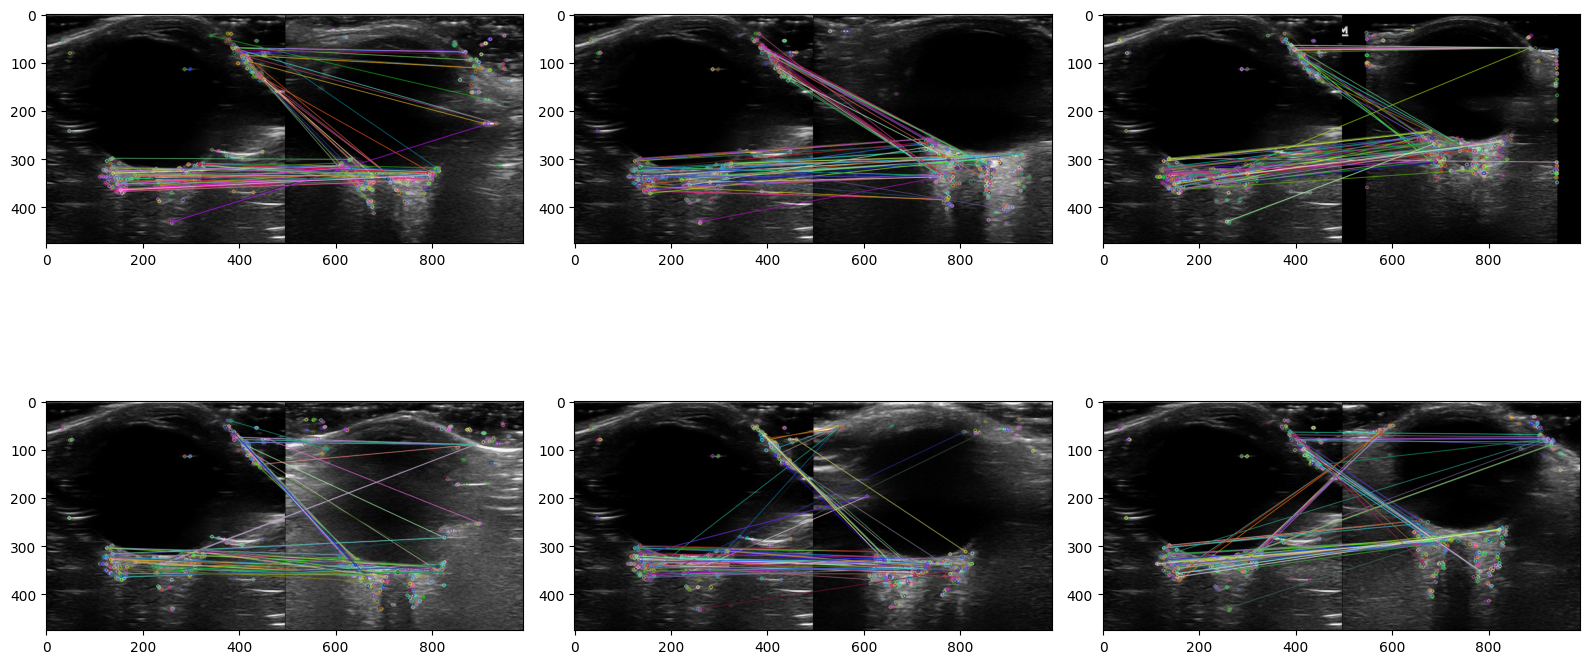

In [7]:
offsets = [np.zeros((2))]    # x, y
deltas = [np.zeros((1, 2))]
selections = [(0)]
match_images = []
for i, image in enumerate(cv_images[1:]):
    offset, delta, selection, match_image = alignImages(cv_images[0], image)
    if offset[1] > 60:
        print(f"i={i+1} {offset=}")
    offsets.append(offset)
    deltas.append(delta)
    selections.append(selection)
    match_images.append(match_image)

half_width = width#//2
fig, ax = plt.subplots(height, half_width)
for i in range(height * half_width):
    ax[i // half_width, i % half_width].imshow(match_images[i])
plt.tight_layout()

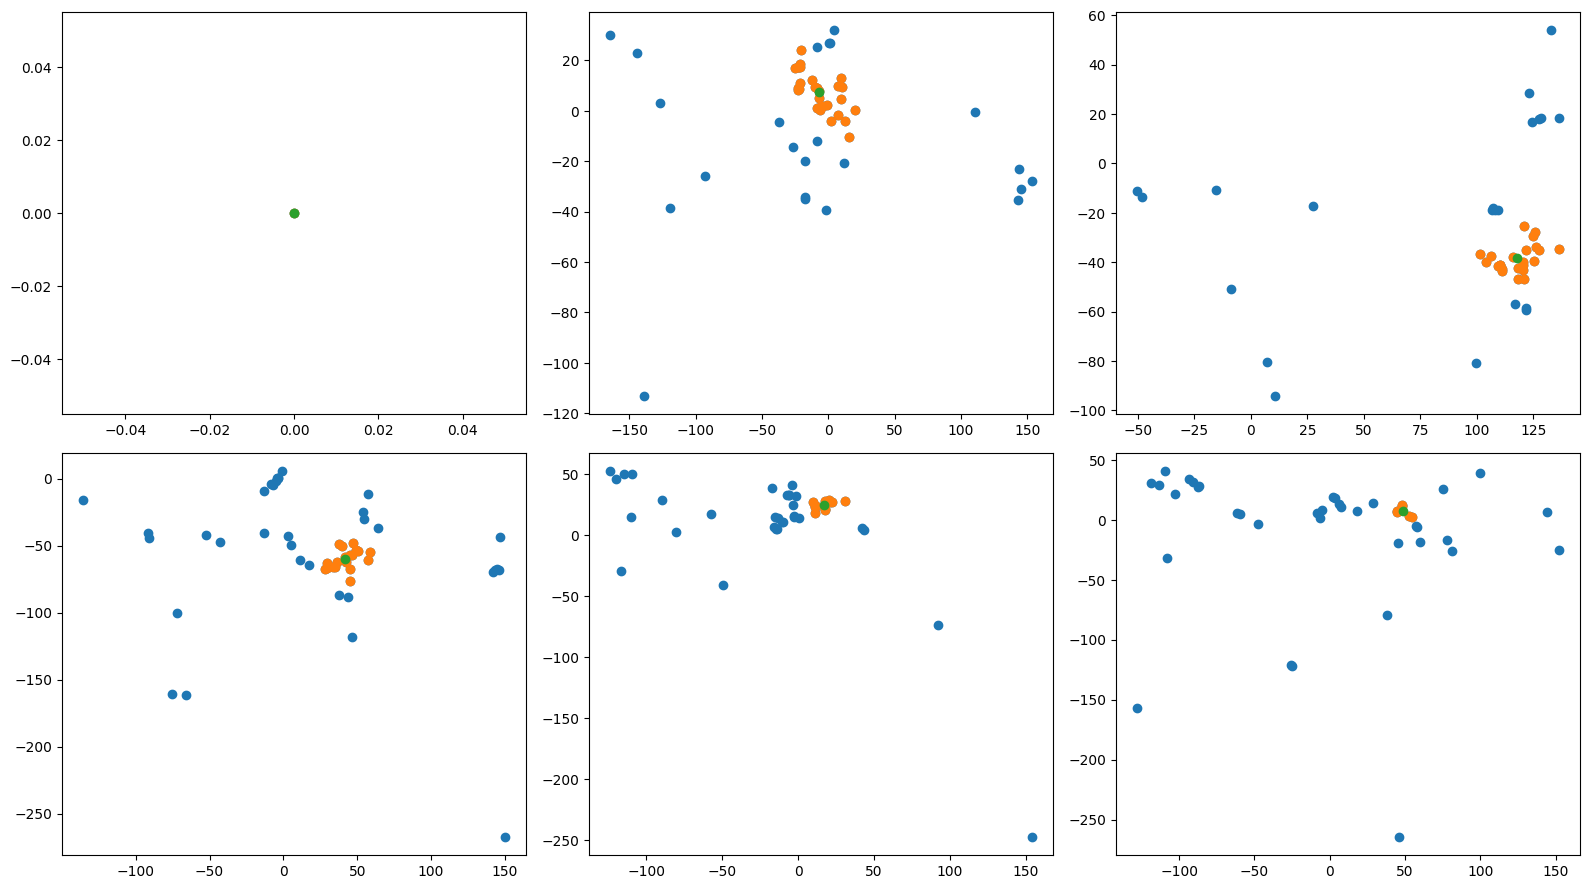

In [8]:
half_width = width# - 1
fig, ax = plt.subplots(height, half_width)
for i in range(height * half_width):
    ax[i // half_width, i % half_width].scatter(deltas[i][:,0],deltas[i][:,1])
    ax[i // half_width, i % half_width].scatter(deltas[i][selections[i],0],deltas[i][selections[i],1])
    ax[i // half_width, i % half_width].scatter(offsets[i][0], offsets[i][1])
plt.tight_layout()

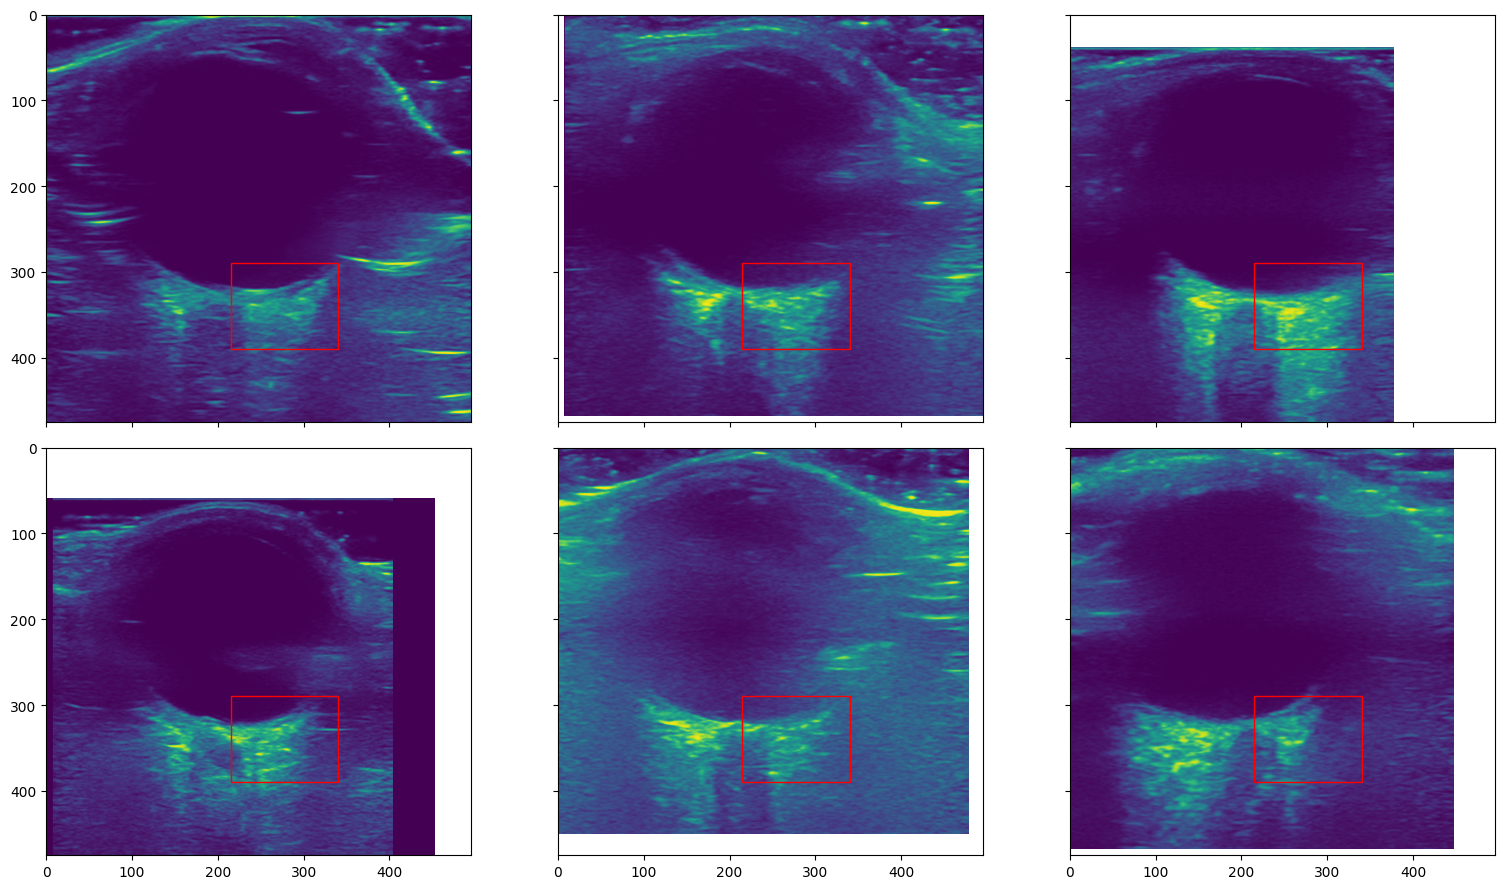

In [9]:
fig, ax = plt.subplots(height, width, sharex=True, sharey=True)

# Display the first images
for i in reversed(range(height * width)):
    offset_left, offset_top = offsets[i]
    offset_left = -offset_left
    offset_top = -offset_top
    offsets[i][0], offsets[i][1]
    ax[i // width, i % width].imshow(cv_images[i], extent = (offset_left, offset_left + img_width, offset_top + img_height, offset_top))
    rect = patches.Rectangle((crop_left, crop_top), crop_width, crop_height, linewidth=1, edgecolor='r', facecolor='none')
    ax[i // width, i % width].add_patch(rect)
plt.tight_layout()

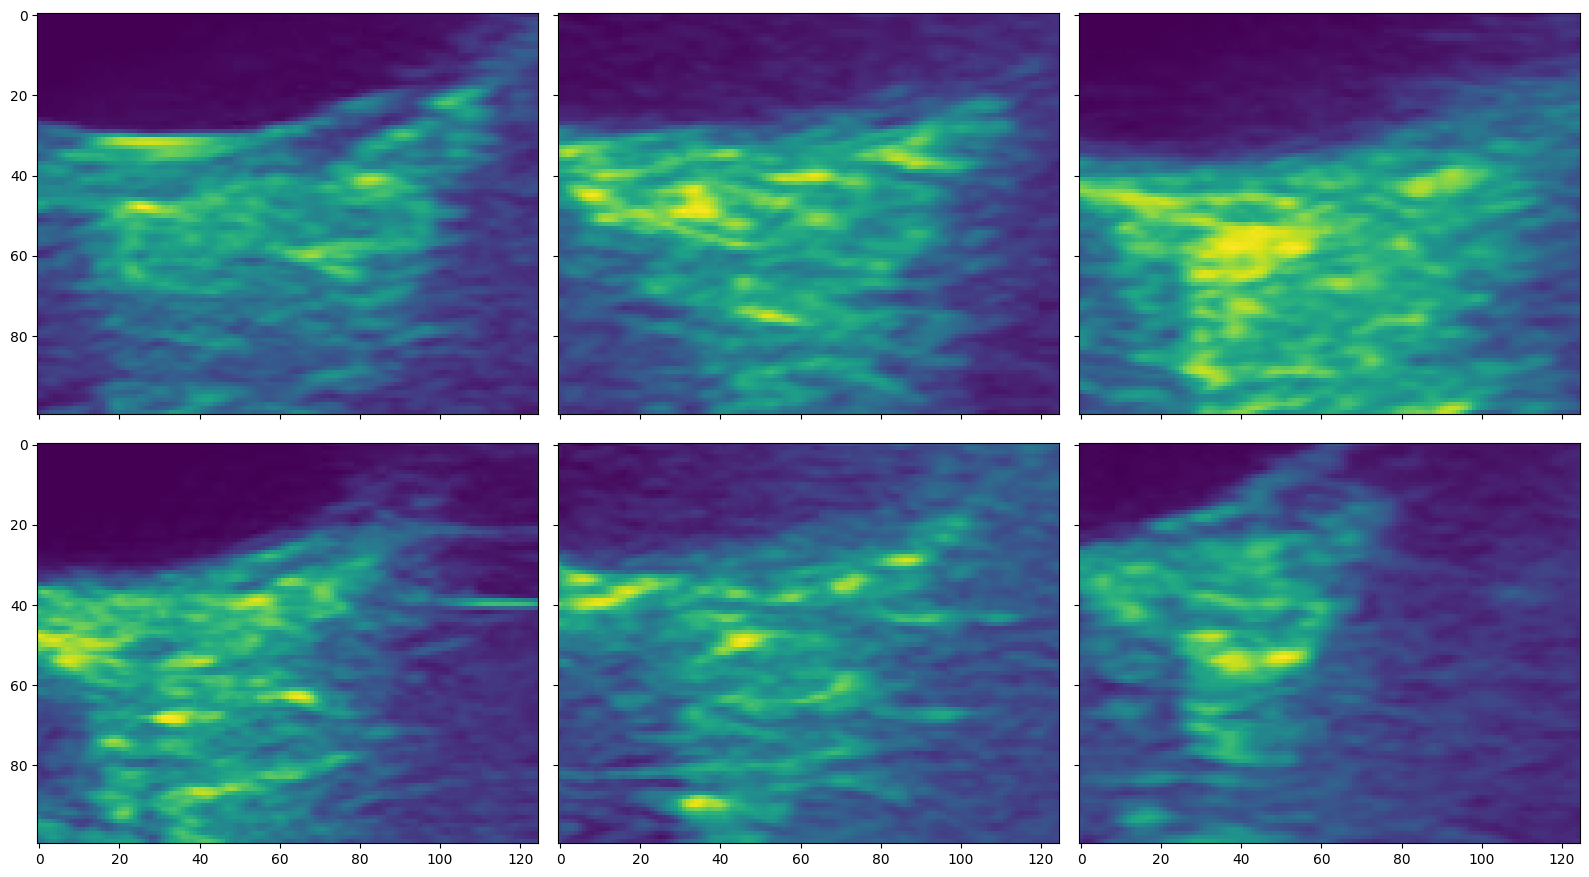

In [10]:
fig, ax = plt.subplots(height, width, sharex=True, sharey=True)

# Display the first images
for i in range(height * width):
    offset_left, offset_top = offsets[i]
    cropped_top = int(crop_top + offset_top)
    cropped_bottom = int(crop_bottom + offset_top)
    cropped_left = int(crop_left + offset_left)
    cropped_right = int(crop_right + offset_left)
    ax[i // width, i % width].imshow(cv_images[i][cropped_top:cropped_bottom,cropped_left:cropped_right])
    #ax[i // width, i % width].imshow(cv_images[i], extent = (offset_left, offset_left + img_width, offset_top + img_height, offset_top))
plt.tight_layout()

In [11]:
# Prepare image dataset
image_dataset = np.zeros((len(cv_images), crop_height, crop_width), dtype=np.uint8)

for i, image in enumerate(cv_images):
    offset_left, offset_top = offsets[i]
    
    # Check if offsets are valid
    if np.isnan(offset_left) or np.isnan(offset_top):
        print(f"Invalid offsets for image {i}: offset_left={offset_left}, offset_top={offset_top}")
        continue

    cropped_top = int(crop_top + offset_top)
    cropped_bottom = int(crop_bottom + offset_top)
    cropped_left = int(crop_left + offset_left)
    cropped_right = int(crop_right + offset_left)
    
    # Ensure the cropped coordinates are within the image bounds
    if (0 <= cropped_top < cropped_bottom <= image.shape[0]) and (0 <= cropped_left < cropped_right <= image.shape[1]):
        cropped_image = image[cropped_top:cropped_bottom, cropped_left:cropped_right]
        image_dataset[i] = cropped_image
    else:
        print(f"Cropping out of bounds for image {i}: "
              f"cropped_top={cropped_top}, cropped_bottom={cropped_bottom}, "
              f"cropped_left={cropped_left}, cropped_right={cropped_right}")

print(image_dataset.shape)


Invalid offsets for image 8: offset_left=nan, offset_top=nan
Invalid offsets for image 10: offset_left=nan, offset_top=nan
Invalid offsets for image 13: offset_left=nan, offset_top=nan
Invalid offsets for image 15: offset_left=nan, offset_top=nan
Invalid offsets for image 57: offset_left=nan, offset_top=nan
Invalid offsets for image 66: offset_left=nan, offset_top=nan
Invalid offsets for image 82: offset_left=nan, offset_top=nan
Invalid offsets for image 86: offset_left=nan, offset_top=nan
Invalid offsets for image 87: offset_left=nan, offset_top=nan
Invalid offsets for image 100: offset_left=nan, offset_top=nan
Invalid offsets for image 116: offset_left=nan, offset_top=nan
Invalid offsets for image 119: offset_left=nan, offset_top=nan
Invalid offsets for image 122: offset_left=nan, offset_top=nan
Invalid offsets for image 137: offset_left=nan, offset_top=nan
Invalid offsets for image 195: offset_left=nan, offset_top=nan
(205, 100, 125)


In [12]:
def alignImages(im1, im2):
    try:
        if len(im1.shape) == 3:
            # Convert images to grayscale
            im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
            im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
        else:
            im1Gray = im1
            im2Gray = im2

        # Detect ORB features and compute descriptors.
        orb = cv2.ORB_create(MAX_FEATURES)
        keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
        keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

        # Match features.
        matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_L1)
        matches = list(matcher.match(descriptors1, descriptors2, None))

        # Sort matches by score
        matches.sort(key=lambda x: x.distance, reverse=False)

        # Remove not so good matches
        numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
        matches = matches[:numGoodMatches]

        if not matches:
            print("No good matches found, returning default offset (0, 0)")
            return (0, 0), np.array([]), [], None

        # Draw top matches
        match_image = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

        # Extract location of good matches
        points1 = np.zeros((len(matches), 2), dtype=np.float32)
        points2 = np.zeros((len(matches), 2), dtype=np.float32)

        deltas = np.zeros((len(matches), 2))  # x, y offset between points matched in both images
        for i, match in enumerate(matches):
            points1[i, :] = keypoints1[match.queryIdx].pt
            points2[i, :] = keypoints2[match.trainIdx].pt
            deltas[i] = points2[i] - points1[i]

        # Remove deltas larger than the image field
        deltas = deltas[np.where((deltas[:, 0] > MIN_DELTA_X) & (deltas[:, 0] < MAX_DELTA_X) & (deltas[:, 1] > MIN_DELTA_Y) & (deltas[:, 1] < MAX_DELTA_Y))]

        if len(deltas) == 0:
            print("No valid deltas found, returning default offset (0, 0)")
            return (0, 0), np.array([]), [], match_image

        # Cluster feature offsets
        associations = cluster_model.fit_predict(deltas)
        clusters = np.unique(associations)
        cluster_points = np.where(associations == 0)  # Cluster #0 is the first cluster, #-1 is the unclustered points
        offset = np.average(deltas[cluster_points], axis=0)  # Return the most likely offset

        return offset, deltas, cluster_points, match_image
    except Exception as e:
        print(f"Exception occurred during alignment: {e}")
        return (0, 0), np.array([]), [], None

# Prepare image dataset
image_dataset = np.zeros((len(cv_images), crop_height, crop_width), dtype=np.uint8)

for i, image in enumerate(cv_images):
    offset_left, offset_top = offsets[i]
    
    # Check if offsets are valid
    if np.isnan(offset_left) or np.isnan(offset_top):
        print(f"Invalid offsets for image {i}: offset_left={offset_left}, offset_top={offset_top}")
        continue

    cropped_top = int(crop_top + offset_top)
    cropped_bottom = int(crop_bottom + offset_top)
    cropped_left = int(crop_left + offset_left)
    cropped_right = int(crop_right + offset_left)
    
    # Ensure the cropped coordinates are within the image bounds
    if (0 <= cropped_top < cropped_bottom <= image.shape[0]) and (0 <= cropped_left < cropped_right <= image.shape[1]):
        cropped_image = image[cropped_top:cropped_bottom, cropped_left:cropped_right]
        image_dataset[i] = cropped_image
    else:
        print(f"Cropping out of bounds for image {i}: "
              f"cropped_top={cropped_top}, cropped_bottom={cropped_bottom}, "
              f"cropped_left={cropped_left}, cropped_right={cropped_right}")

print(image_dataset.shape)


Invalid offsets for image 8: offset_left=nan, offset_top=nan
Invalid offsets for image 10: offset_left=nan, offset_top=nan
Invalid offsets for image 13: offset_left=nan, offset_top=nan
Invalid offsets for image 15: offset_left=nan, offset_top=nan
Invalid offsets for image 57: offset_left=nan, offset_top=nan
Invalid offsets for image 66: offset_left=nan, offset_top=nan
Invalid offsets for image 82: offset_left=nan, offset_top=nan
Invalid offsets for image 86: offset_left=nan, offset_top=nan
Invalid offsets for image 87: offset_left=nan, offset_top=nan
Invalid offsets for image 100: offset_left=nan, offset_top=nan
Invalid offsets for image 116: offset_left=nan, offset_top=nan
Invalid offsets for image 119: offset_left=nan, offset_top=nan
Invalid offsets for image 122: offset_left=nan, offset_top=nan
Invalid offsets for image 137: offset_left=nan, offset_top=nan
Invalid offsets for image 195: offset_left=nan, offset_top=nan
(205, 100, 125)


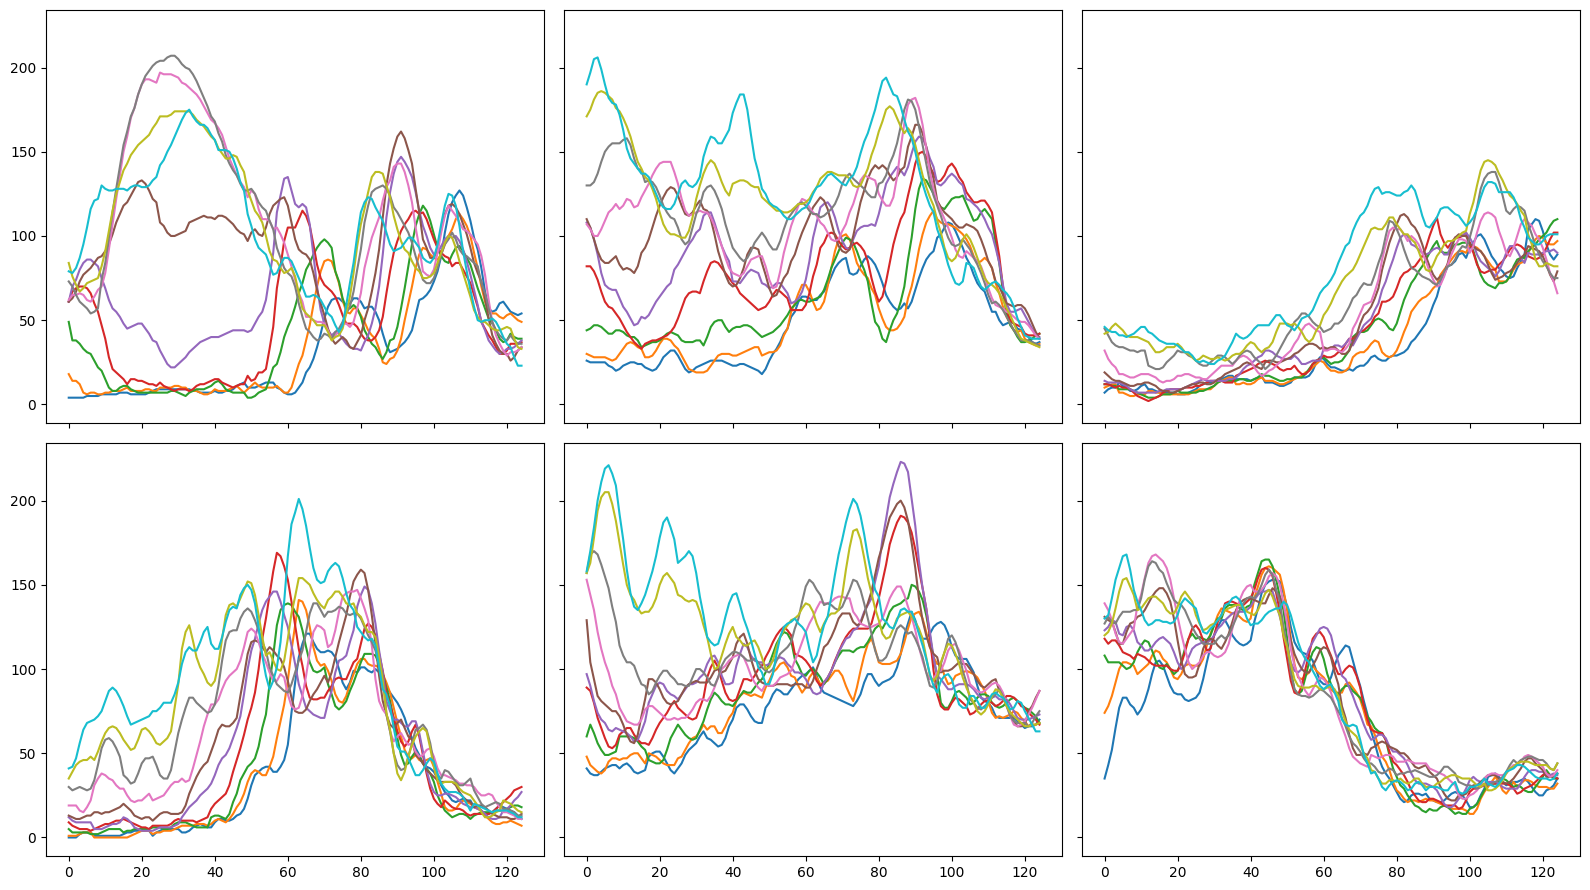

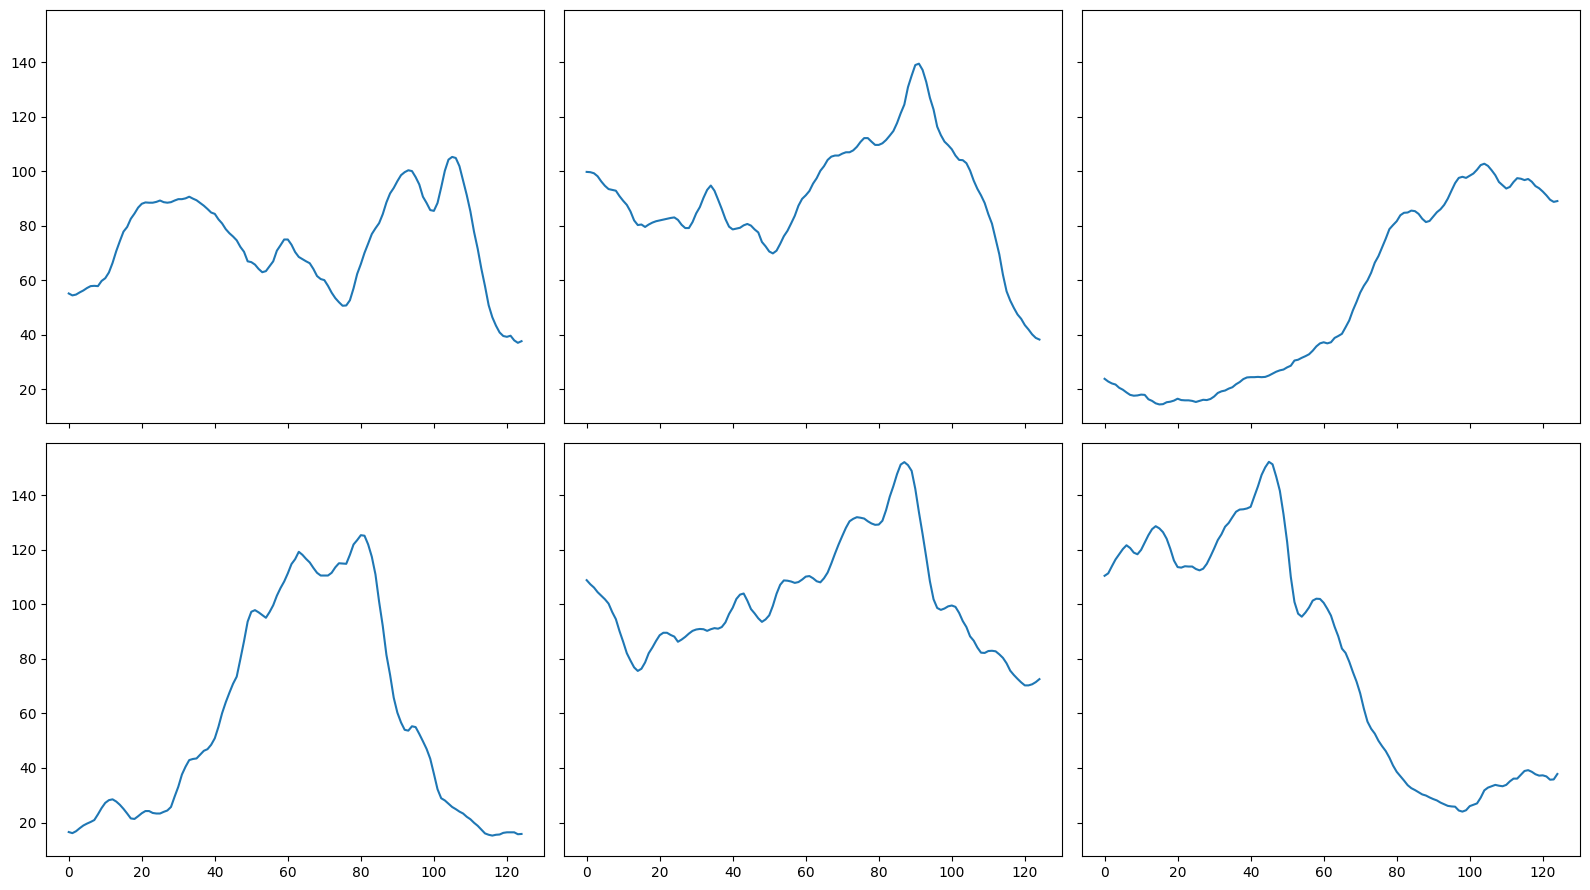

In [13]:
# Plot transects over the region of interest
fig, ax = plt.subplots(height, width, sharex=True, sharey=True)
#img_width = right - left
#img_height = bottom - top
#crop_top = 295
#crop_bottom = crop_top + 150
#crop_left = 200
#crop_right = 350

profiles = []
# Display the first images
for i in range(height * width):
    offset_left, offset_top = offsets[i]
    cropped_top = int(crop_top + offset_top)
    cropped_bottom = int(crop_bottom + offset_top)
    cropped_left = int(crop_left + offset_left)
    cropped_right = int(crop_right + offset_left)
    offset = 30
    #print(cv_images[i][cropped_top+30,cropped_left:cropped_right])
    #cv_images[i][cropped_top+30,cropped_left:cropped_right]
    section = np.swapaxes(cv_images[i][cropped_top+25:cropped_top+35,cropped_left:cropped_right], 0, 1)
    #profile = np.median(section, axis=1)
    profile = np.average(section, axis=1)
    profiles.append(profile)
    ax[i // width, i % width].plot(section)
    #ax[i // width, i % width].plot(profile)
plt.tight_layout()

fig, ax = plt.subplots(height, width, sharex=True, sharey=True)
for i in range(height * width):
    ax[i // width, i % width].plot(profiles[i])
plt.tight_layout()

Mapping ONSD measurements to images to create labels

In [14]:
import pandas as pd
import os

# Load the DataFrame from the Excel file
excel_file = './Meta_pic_3.xlsx'
df = pd.read_excel(excel_file)

# Convert necessary columns to strings and create a label column following the naming convention
df['label'] = df['record_id'].astype(str) + '_image_data_' + df['redcap_repeat_instance'].astype(str) + '_raw_image.jpg'

# Now let's proceed to match and rename the images
documents_dir = './documents'  # Assuming this is your correct directory path

# Iterate over the DataFrame to match, rename images and create an ONSD mapping dictionary
image_onsd_mapping = {}
for index, row in df.iterrows():
    image_name_to_look_for = row['label']
    onsd_value = row['onsd']
    image_path = os.path.join(documents_dir, image_name_to_look_for)

    if os.path.exists(image_path):
        image_onsd_mapping[image_name_to_look_for] = onsd_value
    else:
        print(f"No matching file found for label: {image_name_to_look_for}")

# Display the ONSD mapping
for image_name, onsd_value in image_onsd_mapping.items():
    print(f"{image_name}: {onsd_value}")


MMED-002_image_data_1_raw_image.jpg: 5.4
MMED-002_image_data_2_raw_image.jpg: 5.7
MMED-003_image_data_1_raw_image.jpg: 5.4
MMED-004_image_data_1_raw_image.jpg: 5.2
MMED-004_image_data_2_raw_image.jpg: 5.3
MMED-005_image_data_1_raw_image.jpg: 5.0
MMED-005_image_data_2_raw_image.jpg: 4.8
MMED-006_image_data_1_raw_image.jpg: 5.2
MMED-006_image_data_2_raw_image.jpg: 5.4
MMED-007_image_data_1_raw_image.jpg: 4.9
MMED-007_image_data_2_raw_image.jpg: 5.2
MMED-008_image_data_1_raw_image.jpg: 5.2
MMED-008_image_data_2_raw_image.jpg: 5.1
MMED-009_image_data_1_raw_image.jpg: 4.6
MMED-010_image_data_1_raw_image.jpg: 5.8
MMED-010_image_data_2_raw_image.jpg: 6.0
MMED-011_image_data_1_raw_image.jpg: 4.6
MMED-011_image_data_2_raw_image.jpg: 4.3
MMED-012_image_data_1_raw_image.jpg: 4.4
MMED-012_image_data_2_raw_image.jpg: 4.5
MMED-013_image_data_1_raw_image.jpg: 4.8
MMED-013_image_data_2_raw_image.jpg: 5.0
MMED-014_image_data_1_raw_image.jpg: 5.3
MMED-014_image_data_2_raw_image.jpg: 5.2
MMED-015_image_d

In [4]:
import re

# Function to create a mapping from original to preprocessed filenames
def map_filename_to_preprocessed(filename):
    # Extract a unique identifier from the original filename using a regular expression
    match = re.search(r'\d+', filename)  # Adjust this regex based on the pattern in your filenames
    if match:
        identifier = match.group(0)
        return f"preprocessed_image_{identifier}.png"
    else:
        raise ValueError(f"Cannot extract identifier from filename: {filename}")

# Create a new column with the mapped filenames
df['preprocessed_filename'] = df['filename'].apply(map_filename_to_preprocessed)

# Verify the new column
print(df[['filename', 'preprocessed_filename']])



                                filename       preprocessed_filename
0    MMED-002_image_data_1_raw_image.jpg  preprocessed_image_002.png
1    MMED-002_image_data_2_raw_image.jpg  preprocessed_image_002.png
2    MMED-003_image_data_1_raw_image.jpg  preprocessed_image_003.png
3    MMED-004_image_data_1_raw_image.jpg  preprocessed_image_004.png
4    MMED-004_image_data_2_raw_image.jpg  preprocessed_image_004.png
..                                   ...                         ...
200  MMED-103_image_data_2_raw_image.jpg  preprocessed_image_103.png
201  MMED-104_image_data_1_raw_image.jpg  preprocessed_image_104.png
202  MMED-104_image_data_2_raw_image.jpg  preprocessed_image_104.png
203  MMED-105_image_data_1_raw_image.jpg  preprocessed_image_105.png
204  MMED-105_image_data_2_raw_image.jpg  preprocessed_image_105.png

[205 rows x 2 columns]


In [5]:
import pandas as pd
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

# Correct base directory for your processed images
base_dir = r"./documents/preprocessed_images"

# Assuming you have 'image_labels.csv' in the same directory as your preprocessed images
csv_file = os.path.join(base_dir, 'image_labels.csv')
df = pd.read_csv(csv_file)

# Verify column names
print(df.columns)

# Function to create a mapping from original to preprocessed filenames
def map_filename_to_preprocessed(filename):
    match = re.search(r'\d+', filename)  # Extract the identifier using regex
    if match:
        identifier = match.group(0)
        return f"preprocessed_image_{identifier}.png"
    else:
        raise ValueError(f"Cannot extract identifier from filename: {filename}")

# Create a new column with the mapped filenames
df['preprocessed_filename'] = df['filename'].apply(map_filename_to_preprocessed)

# Verify the new column
print(df[['filename', 'preprocessed_filename']])

# Function to load images based on the corrected path
def load_images(df, base_dir):
    images = []
    for _, row in df.iterrows():
        image_path = os.path.join(base_dir, row['preprocessed_filename'])
        try:
            with Image.open(image_path) as img:
                img = img.resize((128, 128))  # Resize for uniformity
                img_array = np.array(img)
                images.append(img_array)
        except FileNotFoundError:
            print(f"File not found: {image_path}")
    return np.array(images)

# Load images and corresponding labels
images = load_images(df, base_dir)
onsd_measurements = df['label'].values  # Adjusted column name

# Normalize images
images = images / 255.0

# Reshape images to add the single channel dimension for grayscale images
images = images.reshape(images.shape + (1,))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, onsd_measurements, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Index(['filename', 'label'], dtype='object')
                                filename       preprocessed_filename
0    MMED-002_image_data_1_raw_image.jpg  preprocessed_image_002.png
1    MMED-002_image_data_2_raw_image.jpg  preprocessed_image_002.png
2    MMED-003_image_data_1_raw_image.jpg  preprocessed_image_003.png
3    MMED-004_image_data_1_raw_image.jpg  preprocessed_image_004.png
4    MMED-004_image_data_2_raw_image.jpg  preprocessed_image_004.png
..                                   ...                         ...
200  MMED-103_image_data_2_raw_image.jpg  preprocessed_image_103.png
201  MMED-104_image_data_1_raw_image.jpg  preprocessed_image_104.png
202  MMED-104_image_data_2_raw_image.jpg  preprocessed_image_104.png
203  MMED-105_image_data_1_raw_image.jpg  preprocessed_image_105.png
204  MMED-105_image_data_2_raw_image.jpg  preprocessed_image_105.png

[205 rows x 2 columns]
File not found: ./documents/preprocessed_images/preprocessed_image_002.png
File not found: ./documents/

ValueError: Found input variables with inconsistent numbers of samples: [12, 205]

Importing Libaries for simple CNN attempt for regression task of measuring ONSD

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import os
from PIL import Image


2024-06-09 18:49:43.620511: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-09 18:49:44.559093: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-09 18:49:46.594246: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 18:49:49.610060: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Load and split processed image data

In [1]:
import pandas as pd
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

# Correct base directory for your processed images
base_dir = r"./documents/preprocessed_images"

# Assuming you have 'image_labels.csv' in the same directory as your preprocessed images
csv_file = os.path.join(base_dir, 'image_labels.csv')
df = pd.read_csv(csv_file)

# Print column names to verify
print(df.columns)


Index(['filename', 'label'], dtype='object')


In [2]:
import pandas as pd
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

# Correct base directory for your processed images
base_dir = r"./documents/preprocessed_images"

# Assuming you have 'image_labels.csv' in the same directory as your preprocessed images
csv_file = os.path.join(base_dir, 'image_labels.csv')
df = pd.read_csv(csv_file)

# Print column names to verify
print(df.columns)

# Function to load images based on the corrected path
def load_images(df, base_dir):
    images = []
    for _, row in df.iterrows():
        image_path = os.path.join(base_dir, row['filename'])  # Adjusted column name
        try:
            with Image.open(image_path) as img:
                img = img.resize((128, 128))  # Resize for uniformity
                img_array = np.array(img)
                images.append(img_array)
        except FileNotFoundError:
            print(f"File not found: {image_path}")
    return np.array(images)

# Load images and corresponding labels
images = load_images(df, base_dir)
onsd_measurements = df['label'].values  # Adjusted column name

# Normalize images
images = images / 255.0

# Reshape images to add the single channel dimension for grayscale images
images = images.reshape(images.shape + (1,))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, onsd_measurements, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Index(['filename', 'label'], dtype='object')
File not found: ./documents/preprocessed_images/MMED-002_image_data_1_raw_image.jpg
File not found: ./documents/preprocessed_images/MMED-002_image_data_2_raw_image.jpg
File not found: ./documents/preprocessed_images/MMED-003_image_data_1_raw_image.jpg
File not found: ./documents/preprocessed_images/MMED-004_image_data_1_raw_image.jpg
File not found: ./documents/preprocessed_images/MMED-004_image_data_2_raw_image.jpg
File not found: ./documents/preprocessed_images/MMED-005_image_data_1_raw_image.jpg
File not found: ./documents/preprocessed_images/MMED-005_image_data_2_raw_image.jpg
File not found: ./documents/preprocessed_images/MMED-006_image_data_1_raw_image.jpg
File not found: ./documents/preprocessed_images/MMED-006_image_data_2_raw_image.jpg
File not found: ./documents/preprocessed_images/MMED-007_image_data_1_raw_image.jpg
File not found: ./documents/preprocessed_images/MMED-007_image_data_2_raw_image.jpg
File not found: ./documents/pre

ValueError: Found input variables with inconsistent numbers of samples: [0, 205]

In [ ]:
# Reshape image to have a single array per pixel to indicate one channel
image_dataset = image_dataset.reshape(image_dataset.shape[:3] + (1,))

Simple CNN model architecture

In [ ]:
def build_model():
    model = Sequential([
#        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        Conv2D(32, (3, 3), activation='relu', input_shape=(100, 125, 1)),
        MaxPooling2D((3, 3)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1)  # Single output node for regression
    ])
    return model


In [ ]:
model = build_model()
model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])  # MSE is a common loss for regression


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))


Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - loss: 264.1480 - mae: 12.7054 - val_loss: 29.4148 - val_mae: 5.0728
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 24.4619 - mae: 3.7379 - val_loss: 4.4933 - val_mae: 1.6427
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 7.6213 - mae: 2.2301 - val_loss: 6.5134 - val_mae: 2.2814
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 5.5763 - mae: 2.0301 - val_loss: 3.3254 - val_mae: 1.2583
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - loss: 3.9895 - mae: 1.6580 - val_loss: 3.6795 - val_mae: 1.6294
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 3.3934 - mae: 1.5138 - val_loss: 1.7986 - val_mae: 1.0565
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - loss: 2.4461 - mae: 1.2113 - val_loss: 1.4302 - val_mae: 1.0073
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 2.1241 - mae: 1.1595 - val_loss: 1.0425 - val_mae: 0.8390
Epoch 9/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 2.2113 - 

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 1.8599 - mae: 1.1492 - val_loss: 1.1310 - val_mae: 0.8309
Epoch 20/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - loss: 1.9843 - mae: 1.1183 - val_loss: 1.3739 - val_mae: 0.9295
Epoch 21/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 1.9268 - mae: 1.1253 - val_loss: 1.4283 - val_mae: 0.8546
Epoch 22/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - loss: 1.9415 - mae: 1.0846 - val_loss: 1.6390 - val_mae: 0.8781
Epoch 23/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - loss: 1.9424 - mae: 1.1543 - val_loss: 2.6629 - val_mae: 1.4306
Epoch 24/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 2.8607 - mae: 1.4282 - val_loss: 1.5438 - val_mae: 0.8706
Epoch 25/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 2.0182 - mae: 1.2002 - val_loss: 2.0429 - val_mae: 1.2105


In [ ]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.0460 - mae: 1.2208
Test MAE: 1.2105211019515991


In [ ]:
# Make predictions
predictions = model.predict(X_test)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


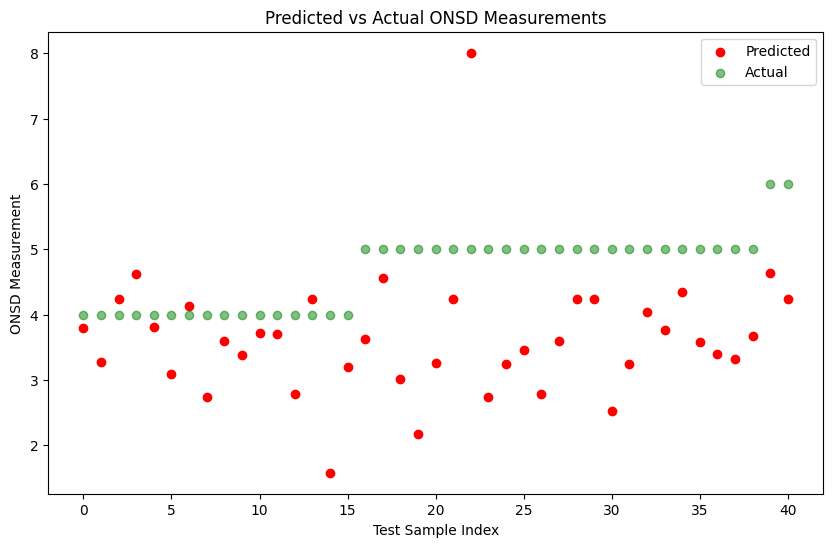

In [ ]:
import matplotlib.pyplot as plt

order = y_test.argsort(axis=None).reshape(predictions.shape)
sorted_predictions = predictions.ravel()[order]
sorted_data = y_test.ravel()[order]

plt.figure(figsize=(10, 6))
plt.scatter(range(len(predictions)), sorted_predictions, color='r', label='Predicted')
plt.scatter(range(len(y_test)), sorted_data, color='g', alpha=0.5, label='Actual')
plt.title('Predicted vs Actual ONSD Measurements')
plt.xlabel('Test Sample Index')
plt.ylabel('ONSD Measurement')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 1.2105210001875715
Root Mean Square Error (RMSE): 1.4292917213124368


[[6.         4.23724508]
 [4.         1.5806098 ]
 [4.         4.23724508]
 [5.         3.32451344]
 [4.         2.78143454]
 [4.         3.70301223]
 [4.         3.71839714]
 [5.         3.39037037]
 [4.         3.19406271]
 [5.         3.5837574 ]]


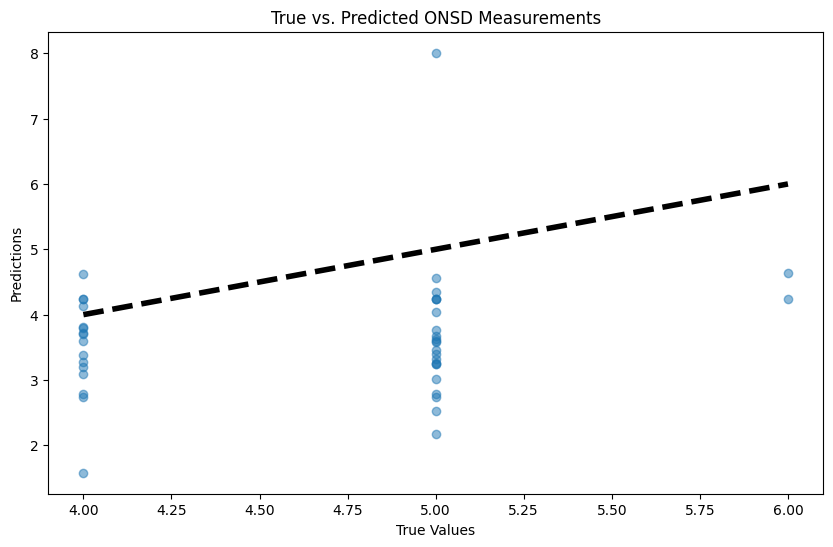

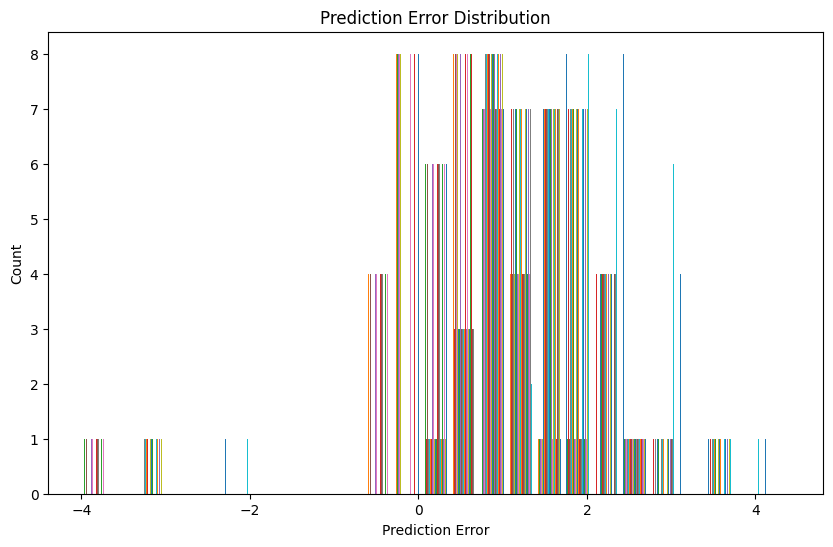

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'predictions' is a numpy array of your model's predicted ONSD measurements
# and 'y_test' is the true ONSD measurements

# Compare predictions with actual values
comparison = np.column_stack((y_test, predictions))

# Print the first few comparisons to check
print(comparison[:10])

# Plotting the true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line for reference
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted ONSD Measurements')
plt.show()

# Plotting the error distribution
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=25)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Prediction Error Distribution')
plt.show()


Trying a different architecture to see if it improves performance

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_enhanced_model(input_shape=(100, 125, 1)):
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Second Conv Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Third Conv Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1))  # Output layer for regression

    return model


Building what I hope to be an enhanced model 

In [ ]:
model = build_enhanced_model()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Now you would train your model, perhaps with more epochs or different batch sizes
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))


Epoch 1/50


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 570ms/step - loss: 25.8228 - mae: 4.5244 - val_loss: 607.4271 - val_mae: 23.1117
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 544ms/step - loss: 25.1804 - mae: 4.6846 - val_loss: 45.7972 - val_mae: 6.5888
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 559ms/step - loss: 21.7112 - mae: 4.4104 - val_loss: 7.4161 - val_mae: 2.2221
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 572ms/step - loss: 21.7996 - mae: 4.4351 - val_loss: 22.6765 - val_mae: 4.6472
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 556ms/step - loss: 19.3157 - mae: 4.2397 - val_loss: 50.7838 - val_mae: 6.9147
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 533ms/step - loss: 18.3772 - mae: 4.1064 - val_loss: 44.2305 - val_mae: 6.4305
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 539ms/step - loss: 19.7234 - mae: 4.1837 - val_loss: 42.2537 - val_mae: 6.1826
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 545ms/step - loss: 17.9397 - mae: 3.9889 - val_loss: 40.8025 - val_mae: 6.0255
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 541ms/step - loss: 17.9508 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Mean Absolute Error (MAE): 1.2753073529499332
Mean Squared Error (MSE): 8.15546340302107
Root Mean Squared Error (RMSE): 2.855777197720626


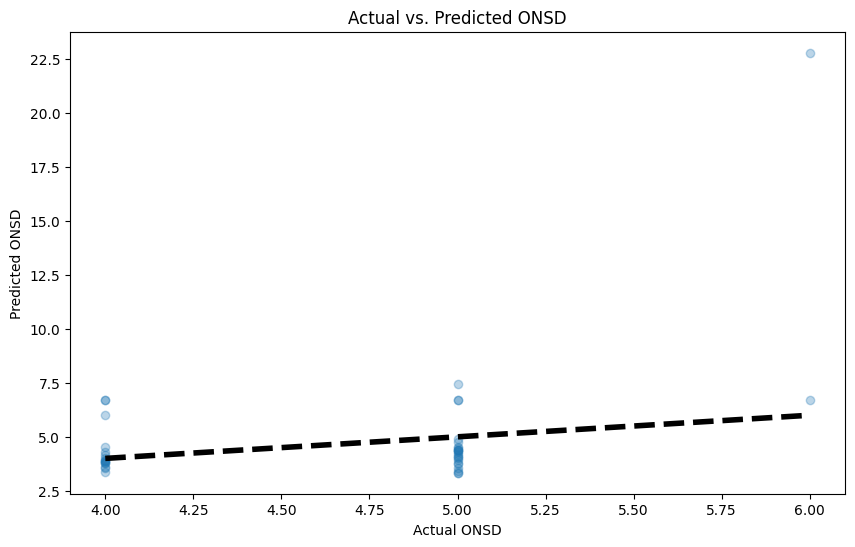

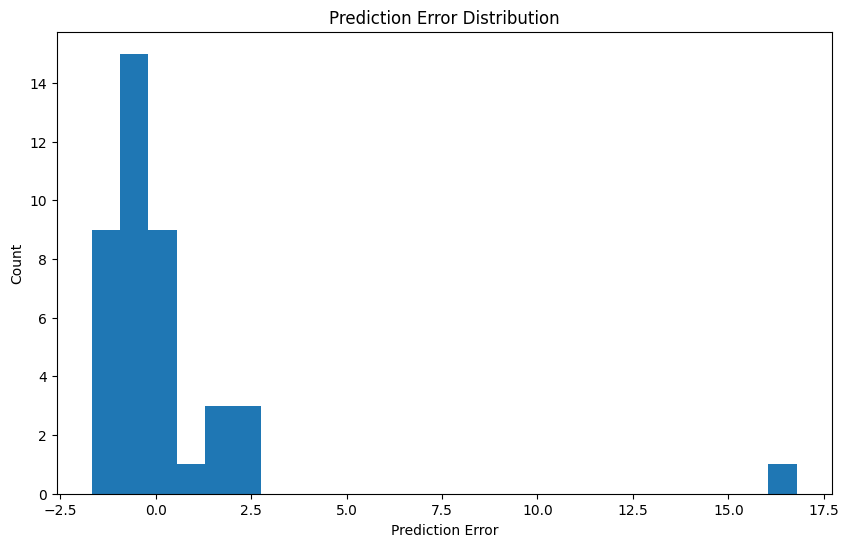

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Assuming 'X_test' and 'y_test' are your test datasets

# Make predictions on the test set
predictions = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)  # RMSE is just the square root of MSE

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plotting Actual vs. Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual ONSD')
plt.ylabel('Predicted ONSD')
plt.title('Actual vs. Predicted ONSD')
plt.show()

# Plotting the error distribution
errors = predictions.flatten() - y_test
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=25)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Prediction Error Distribution')
plt.show()


In [ ]:
# Assuming 'predictions' is a numpy array with the predicted ONSD values
# And 'y_test' is the actual ONSD measurements from the test set

# Convert predictions to a 1D array if it's not already
predictions = predictions.flatten()

# Create a DataFrame for a cleaner display
comparison_df = pd.DataFrame({'Actual ONSD': y_test, 'Predicted ONSD': predictions})

# Add a column for absolute error
comparison_df['Absolute Error'] = np.abs(comparison_df['Actual ONSD'] - comparison_df['Predicted ONSD'])

# Display several examples
print(comparison_df.head(10))


   Actual ONSD  Predicted ONSD  Absolute Error
0            6        6.703022        0.703022
1            4        5.992666        1.992666
2            4        6.703022        2.703022
3            5        3.937952        1.062048
4            4        4.523893        0.523893
5            4        3.769592        0.230408
6            4        3.857696        0.142304
7            5        4.759980        0.240020
8            4        4.033502        0.033502
9            5        4.007077        0.992923


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile model with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Add early stopping to halt training when validation loss increases
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model with early stopping
history = model.fit(
    X_train, y_train, 
    batch_size=32, 
    epochs=50, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)


Epoch 1/50


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 599ms/step - loss: 2.3054 - mae: 1.1725 - val_loss: 7.9210 - val_mae: 1.3676
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 559ms/step - loss: 2.5859 - mae: 1.2355 - val_loss: 7.4836 - val_mae: 1.2517
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 556ms/step - loss: 1.9979 - mae: 1.0838 - val_loss: 7.3233 - val_mae: 1.2099
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 566ms/step - loss: 2.3446 - mae: 1.2333 - val_loss: 6.7550 - val_mae: 1.0410
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 560ms/step - loss: 2.3314 - mae: 1.1736 - val_loss: 6.2715 - val_mae: 1.0049
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 552ms/step - loss: 2.8730 - mae: 1.2743 - val_loss: 6.2109 - val_mae: 1.0189
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 539ms/step - loss: 2.2026 - mae: 1.1881 - val_loss: 6.1000 - val_mae: 1.0282
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 544ms/step - loss: 2.9135 - mae: 1.2914 - val_loss: 5.9626 - val_mae: 1.0423
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 554ms/step - loss: 1.9305 - mae: 1.1292 - va

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x749ffca48ca0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Mean Absolute Error (MAE): 0.8089885013859447
Mean Squared Error (MSE): 2.0412810506561474
Root Mean Squared Error (RMSE): 1.4287340727567701


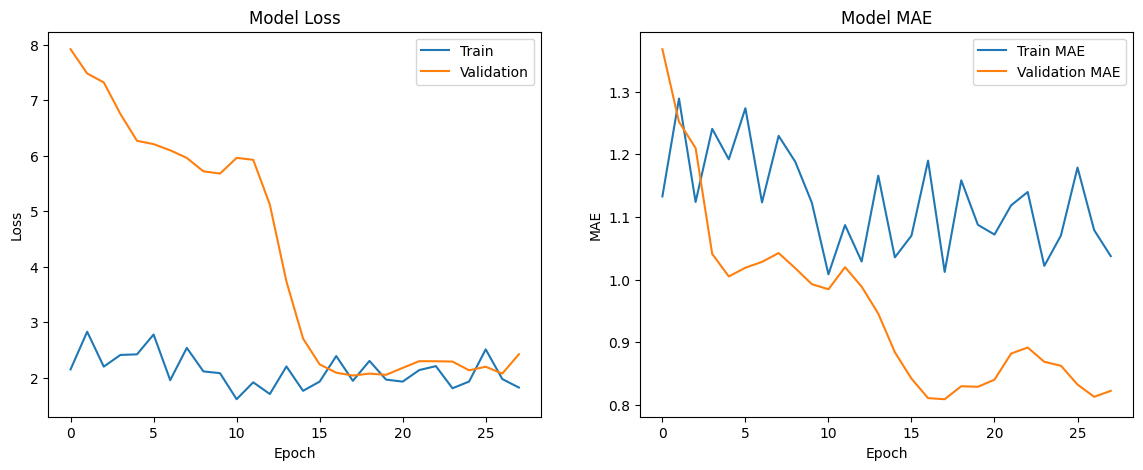

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions
predictions = model.predict(X_test).flatten()

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the training history
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()
